# Monte Carlo for Hypothesis Testing

## Mean example

In [1]:
using Distributions
using CairoMakie

# data
x = [31.94, 140.44, 39.12, 82.47, 20.64, 37.89, 1.14, 15.4, 121.91, 15.59]
n = length(x)

# theoretical estimator and pvalue
σₜ= 47.8 / sqrt(10)
T₀ = Normal(72, σₜ)
pval = cdf(T₀, mean(x)) * 2

# Monte Carlo sampling and pvalue approximation
X = Normal(72, 47.8)
m = 10000
statistic = zeros(m)
for i = 1:m
    samples = rand(X, n)
    statistic[i] = mean(samples)
end
pval_mc = 2 * (sum(statistic .< mean(x)) / m)

0.1486

visualize

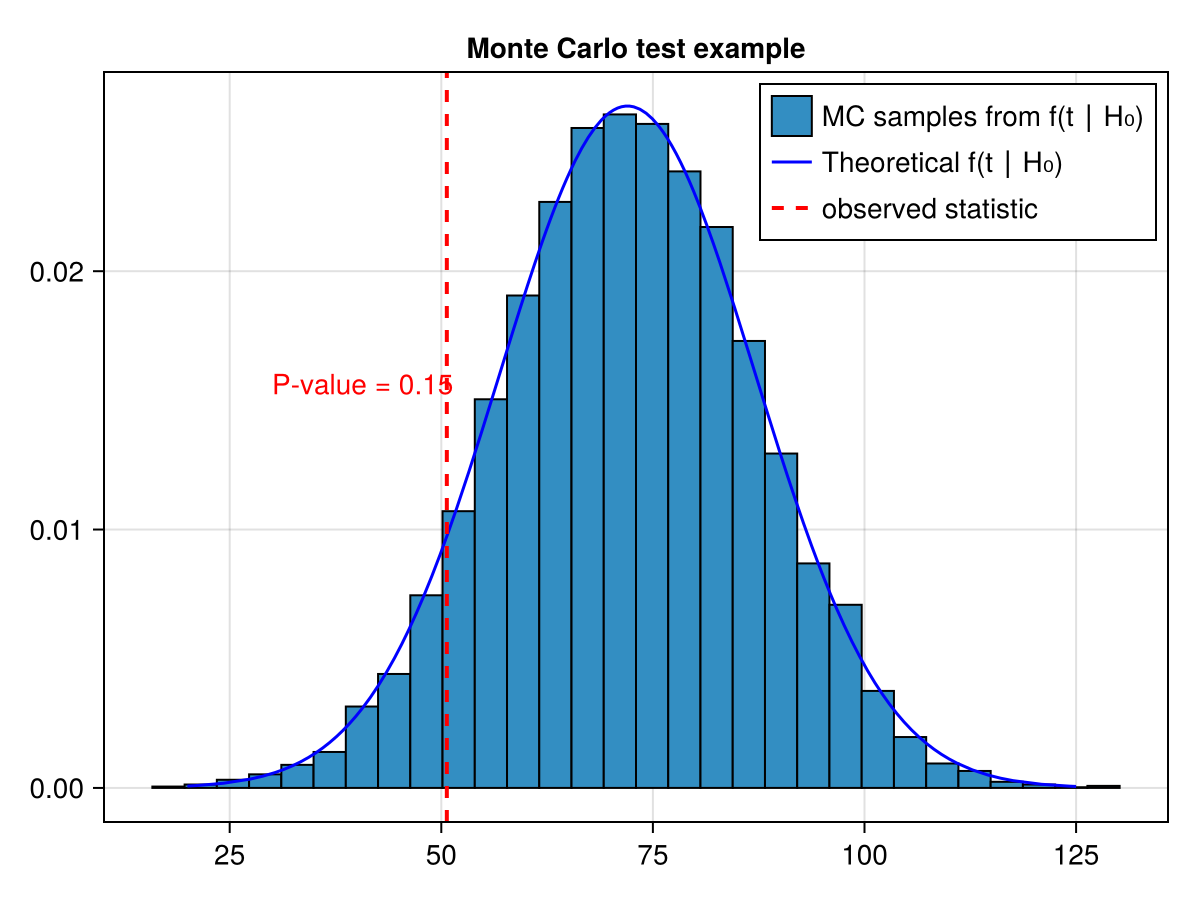

In [2]:
fig = hist(statistic, normalization = :pdf, bins = 30, strokewidth = 1,
    label = "MC samples from f(t ∣ H₀)", axis = (title = "Monte Carlo test example",))
lines!(20..125, x -> pdf.(T₀, x), color = :blue, label = "Theoretical f(t ∣ H₀)")
vlines!([mean(x)], color = :red, linestyle = :dash, linewidth = 2,
    label = "observed statistic")
text!([30], [0.015], text = ["P-value = $(round(pval_mc, digits = 2))"],
    color = :red
)
axislegend()
fig

savefig("data/figures/05-example-normal-pvalmc.png")

## Mean example with Exponential distribution

In [3]:
# data
X = Exponential(72)
x = [31.94, 140.44, 39.12, 82.47, 20.64, 37.89, 1.14, 15.4, 121.91, 15.59]

# asymptotic estimator and pvalue
σₜ= 47.8 / sqrt(10)
T₀ = Normal(72, σₜ)
pval = cdf(T₀, mean(x)) * 2

# Monte Carlo sampling and pvalue approximation
n = length(x)
m = 10000
statistic = zeros(m)
for i = 1:m
    samples = rand(X, n)
    statistic[i] = mean(samples)
end
pval_mc = 2 * (sum(statistic .< mean(x)) / m)

0.3522

visualize

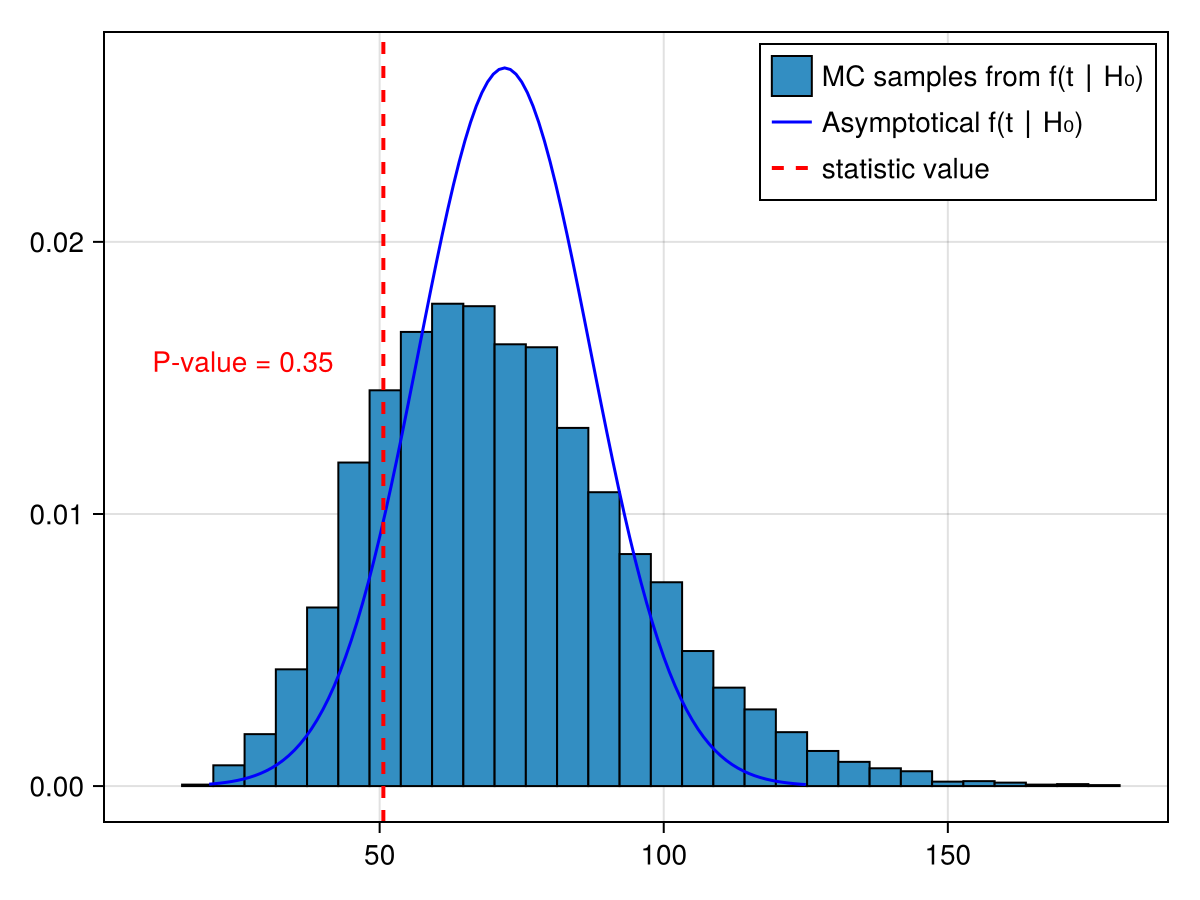

In [4]:
fig = hist(statistic, normalization = :pdf, bins = 30, strokewidth = 1,
    label =  "MC samples from f(t ∣ H₀)")
lines!(20:125, x -> pdf.(T₀, x), color = :blue, label = "Asymptotical f(t ∣ H₀)")
vlines!([mean(x)], color = :red, linestyle = :dash, linewidth = 2,
    label = "statistic value")
text!([10], [0.015], text = ["P-value = $(round(pval_mc, digits = 2))"], color = :red)
axislegend()
fig

savefig("data/figures/05-example-exponential-pvalmc.png")

## Monte Carlo test for point processes

Let consider the ocurrence of events in a period of time $[0,10]$ with intensity
function $\lambda(t) = sin(t) + 1$. Simulate $200$ events from this temporal point
process.

In [5]:
λ(t) = sin(t) + 1
M = 2 / (1/10)

20.0

Remember that we can use rejection sampling to obtain a realization of this process.

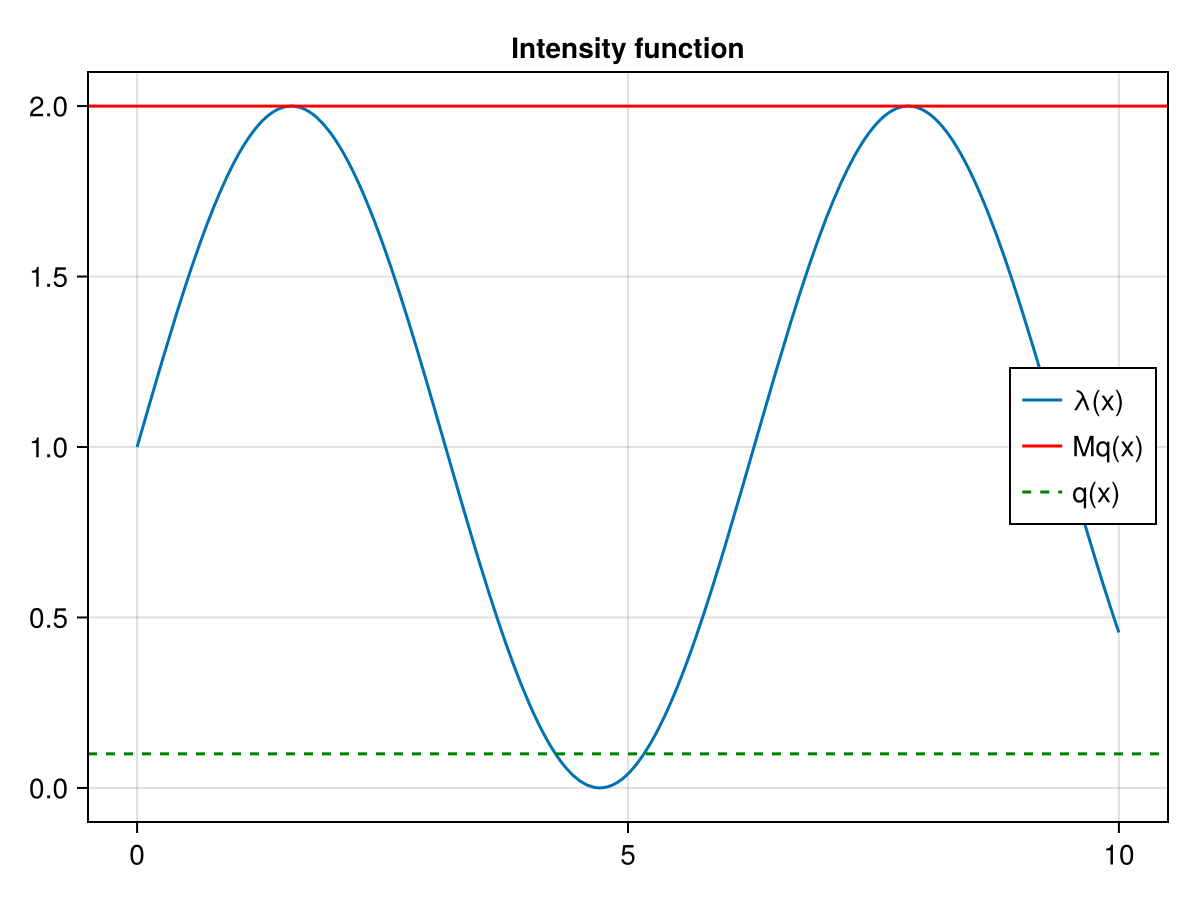

In [6]:
fig = lines(0..10, λ, label = "λ(x)"; axis = (title = "Intensity function",))
hlines!(M * 1/10, label = "Mq(x)", color = :red)
hlines!(1/10, label = "q(x)", color = :green, linestyle = :dash)
axislegend(position = :rc)
fig

In [7]:
n = 200
xsample = zeros(n)
naccepted = 0
while naccepted < n
    x = 10 * rand()
    r = λ(x) / (M * 1/10)
    if rand() < r
        global naccepted += 1
        xsample[naccepted] = x
    end
end

Let's visualize the point process realization.

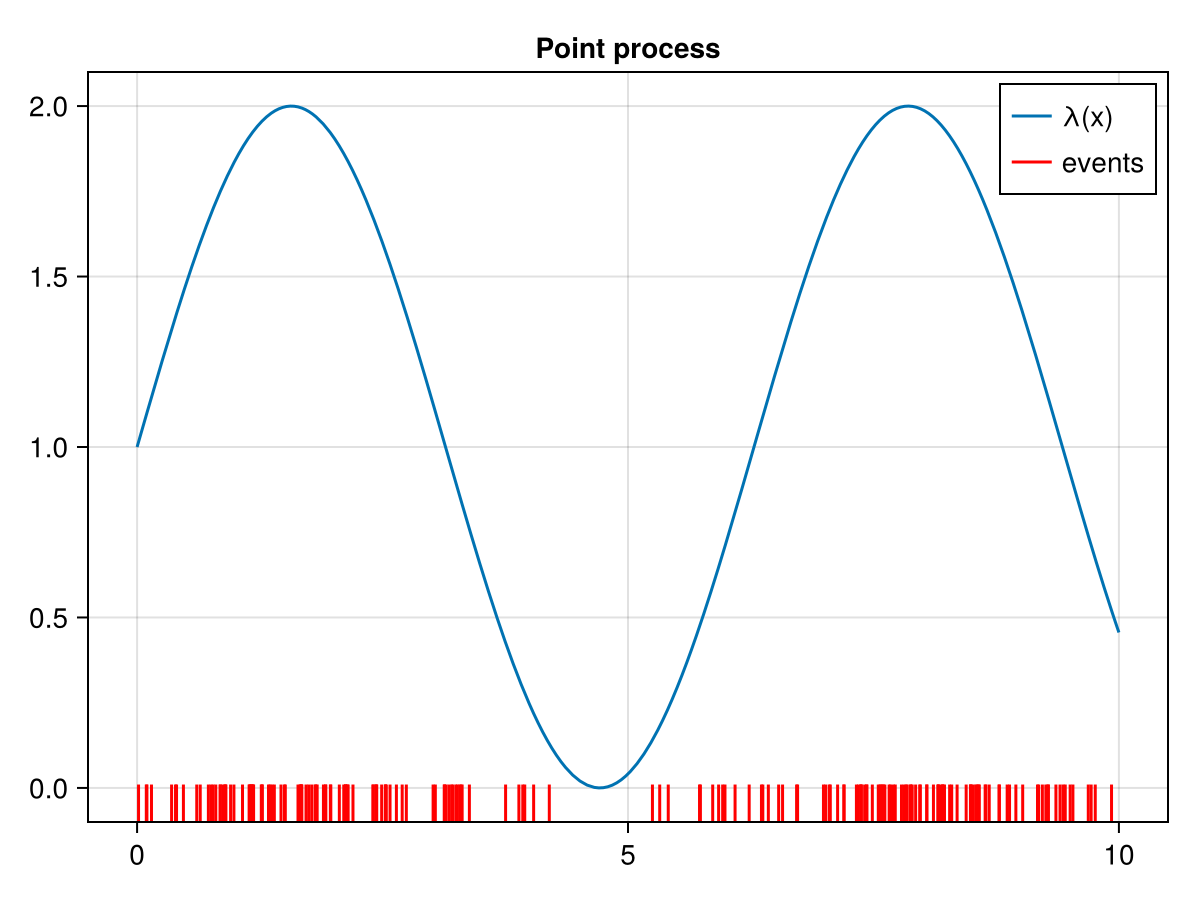

In [8]:
fig = lines(0..10, λ, label = "λ(x)"; axis = (title = "Point process",))
vlines!(xsample, ymax = 0.05, color = :red, label = "events")
axislegend()
fig

Hypothesis testing to check if the events are uniformly distributed.

In [9]:
catgories  = floor.(sort(xsample))
cat = unique(catgories)
observed = map(x -> sum(catgories .== x), cat)
expected = length(xsample) / length(cat)
stat_value = sum(((observed .- expected) .^ 2) / expected)

m = 4000
mc_test = zeros(m)
for i = 1:m
    mc_sample = rand(Uniform(0, 10), 200)
    mc_observed = map(x -> sum(floor.(sort(mc_sample)) .== x), cat)
    mc_value = sum(((mc_observed .- expected) .^ 2) / expected)
    mc_test[i] = mc_value
end

pval = sum(mc_test .> stat_value) / m

0.0

In [10]:
# visualize
fig = hist(mc_test, label = "MC samples ∣ H₀", normalization = :pdf, bins = 20,
    strokewidth = 1; axis = (title = "Monte Carlo test for homogeneity",))
vlines!([stat_value], label = "statistic value", color = :red, linestyle = :dash,
    linewidth = 2,)
text!([45], [0.05], text = ["P-value = $(round(pval, digits = 2))"], color = :red)
axislegend()
fig

using Distributions
using CairoMakie

## Simulate

In [11]:
μ = [0.0, 0.0]
ρ = 0.01
σ₁ = 0.3
σ₂ = 0.3
R = [σ₁^2 ρ*σ₁*σ₂; ρ*σ₁*σ₂ σ₂^2]

2×2 Matrix{Float64}:
 0.09    0.0009
 0.0009  0.09

In [12]:
X = MvLogNormal(MvNormal(μ, R))

Distributions.MvLogNormal{Float64, PDMats.PDMat{Float64, Matrix{Float64}}, Vector{Float64}}(
dim: 2
μ: [0.0, 0.0]
Σ: [0.09 0.0009; 0.0009 0.09]
)


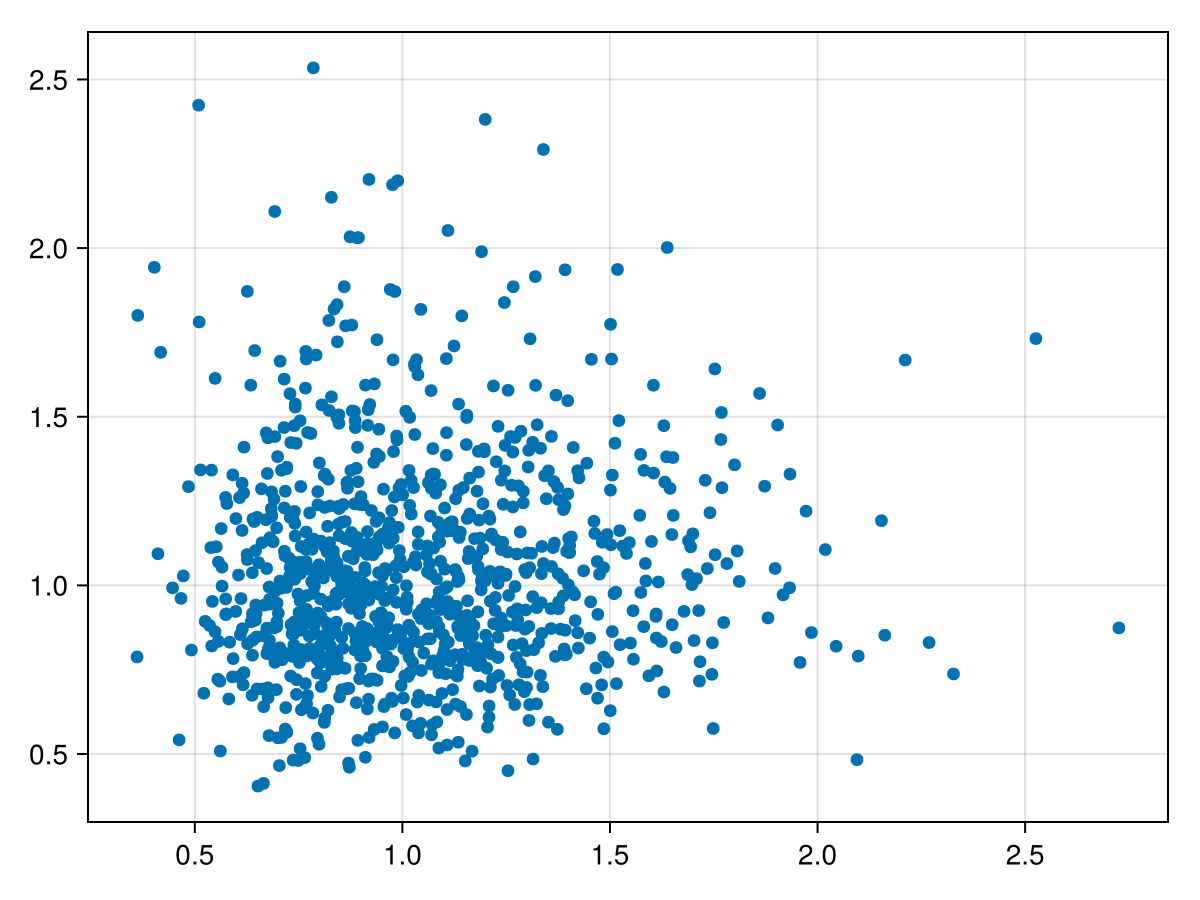

In [13]:
n = 1000
x = rand(X, 1000)
cor_obs = cor(x[1, :], x[2, :])
scatter(x[1,:], x[2,:])

## Monte Carlo test

In [14]:
X = LogNormal(μ[1], σ₁)
m = 10000
statistic = zeros(m)
for i = 1:m
    xmc = rand(X, n)
    ymc = rand(X, n)
    statistic[i] = cor(xmc, ymc)
end

fig = hist(statistic, strokewidth = 1)
vlines!(cor_obs, color = :red)
fig

pval_mc = 2 * (sum(statistic .> cor_obs) / m)

0.2734

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*